## Imports

In [1]:
import importlib
import tensorflow_config

from tensorflow import keras 
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ProgbarLogger, TensorBoard, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.losses import *

import cv2
import os, sys
import numpy as np
import random
import matplotlib.pyplot as plt
import datetime

from vgg_like_smaller_convnets import smallVGGLikeNets
from visualization_util import visualize_images_in_grid, summarize_diagnostics
from custom_callbacks import customCallbacks
%matplotlib inline

## helper functions

In [2]:
get_abs_img_path = lambda img_dir:[os.path.join(img_dir, i) for i in os.listdir(img_dir)] 

## configure dataset path 

In [3]:
base_dir = '/home/acer/Downloads/data/cat_vs_dog_filtered'

In [4]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


## get absolute paths of image categories

In [6]:
abs_cats_imgs = get_abs_img_path(train_cats_dir)
abs_dogs_imgs = get_abs_img_path(train_dogs_dir)

## visualize random images

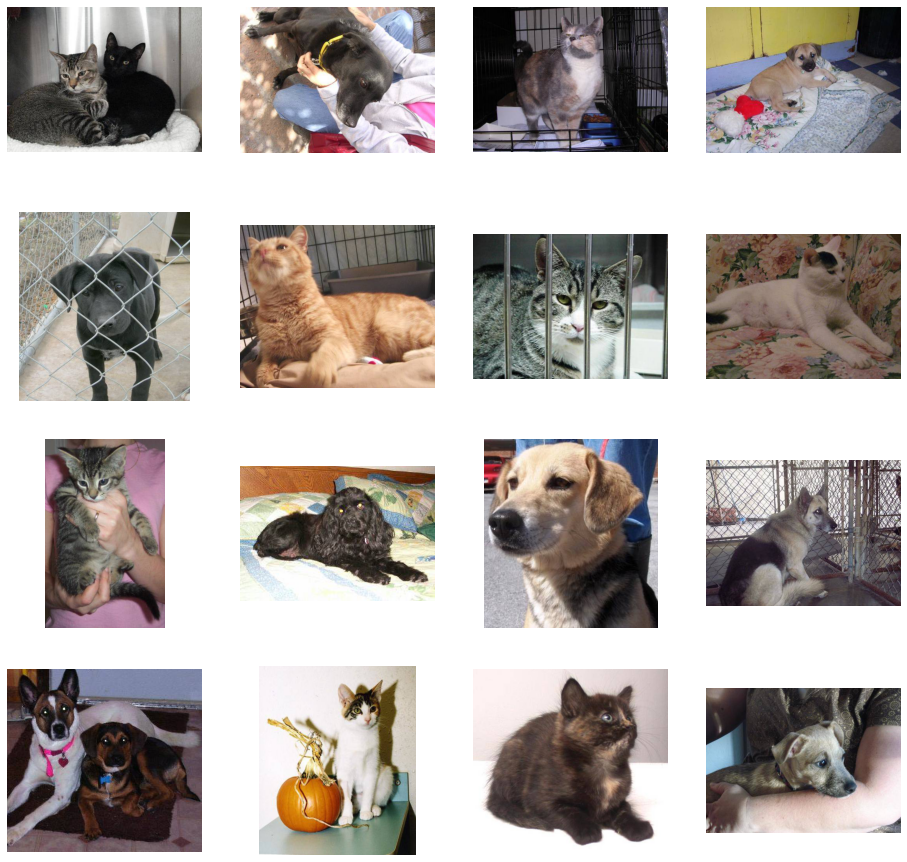

In [7]:
visualize_images_in_grid(abs_dogs_imgs+abs_cats_imgs, grid_size=4)

## prepare data for loading

In [8]:
## these params are used in many parts therefore declaring it separately here
image_size = 224
batch_size = 32

In [9]:
target_size = (image_size, image_size)
class_mode='categorical' # binary if binary classification is needed
validation_split_percent=0.33

In [10]:
# IF IMAGE AUGMENTATION IS NEEDED ALONG WITH SCALING, INITIALIZE IT HERE
train_datagen = ImageDataGenerator(rescale=1.0/255)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(image_size, image_size),
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,                                                    
                                                )
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(image_size, image_size),
                                                              class_mode=class_mode,
                                                              batch_size=batch_size
                                                )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## instantiate small vgg like network class 

In [11]:
num_classes=2
input_shape=(image_size, image_size, 3)

In [12]:
sVGGNets = smallVGGLikeNets(num_classes=num_classes, input_shape=input_shape, class_mode=class_mode)

In [13]:
model = sVGGNets.define_one_block_vgg_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## set hyperparameters, compile model, print summary and model figure

In [14]:
learning_rate = 1e-4
momentum = 0.9
optimizer = SGD(lr=learning_rate, momentum=momentum)
loss = categorical_crossentropy

In [15]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               51380352  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 51,381,506
Trainable params: 51,381,506
Non-trainable params: 0
_________________________________________________________________


## train model

In [17]:
abs_weights_path = '/home/acer/keras-learnings/saved_models'
final_weights_path = os.path.join(os.path.abspath(abs_weights_path), 'model_weights.h5')

In [18]:
callback_list = [
    ProgbarLogger(count_mode='steps'),
    ModelCheckpoint(filepath=final_weights_path, monitor='val_loss', verbose=1, save_best_only=True),
    TensorBoard(log_dir='./logs', write_graph=True),
    customCallbacks()
]

epochs = 12
steps_per_epoch = train_generator.n//batch_size
validation_steps = validation_generator.n//batch_size

In [19]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              verbose=1,
                              callbacks=callback_list,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              workers=4
)

Epoch 1/12
Epoch 1/12
62/62 [==============================] - 5s 86ms/step - loss: 0.7596 - acc: 0.5152 - val_loss: 0.6901 - val_acc: 0.5111

Epoch 00001: val_loss improved from inf to 0.69006, saving model to /home/acer/keras-learnings/saved_models/model_weights.h5
62/62 [==============================] - 6s 97ms/step - loss: 0.7596 - acc: 0.5152 - val_loss: 0.6901 - val_acc: 0.5111
Epoch 2/12
Epoch 2/12
62/62 [==============================] - 3s 47ms/step - loss: 0.6834 - acc: 0.5528 - val_loss: 0.6729 - val_acc: 0.5806

Epoch 00002: val_loss improved from 0.69006 to 0.67292, saving model to /home/acer/keras-learnings/saved_models/model_weights.h5
62/62 [==============================] - 3s 56ms/step - loss: 0.6834 - acc: 0.5528 - val_loss: 0.6729 - val_acc: 0.5806
Epoch 3/12
Epoch 3/12
62/62 [==============================] - 3s 46ms/step - loss: 0.6692 - acc: 0.5798 - val_loss: 0.6682 - val_acc: 0.5827

Epoch 00003: val_loss improved from 0.67292 to 0.66825, saving model to /home

## run diagnostics, evaluate model

In [20]:
diagnostics_figure_path = '/home/acer/keras-learnings'
diagnostics_figure_file_name = os.path.join(diagnostics_figure_path, 'diagnostics_plot_'+datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")+'.jpg')

In [21]:
# # evaluate model
# _, acc = model.evaluate_generator(test_generator, steps=len(test_it))
# print('> %.3f' % (acc * 100.0))

# learning curves
summarize_diagnostics(history, save_fig=True, figure_name=diagnostics_figure_file_name)
# summarize_diagnostics(history)

# References
1. https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/
